In [1]:
targetHeightToUse                = 427
referencePoolCombination         = [427]
shortOrLong                      = 'L'      # Default 'S'hort uses ONE FILE; 'L'ong EVERY FILE.
maskNumber                       = 2        # Default maskNumber = 2
userTestingNumberFrames          = 0        # Default userTestingNumberFrames = 3
VL                               = 0        # Default very verbose
# ( VL 0 Minimal ; VL 3 verbose and diagnostic, for development; VL 4 debugging / exhaustive / intensive, at pixel value level )

userLabel                        = "labelOWA100"  # User determined for now
targetName                       = "target" # User determined for now
dynMask4ple                      =  ( False , 0 , 0 , 0 )
dynMask4ple                      =  ( True , 1 , 0 , 0 )
runWedgeDecided                  = "A" # Default at least for the MinTest, MedTest, TypTest

## Demo of STIS.py for pyklip :
- This demo is set to produce the pyklip results for the V-AU-MIC star, which has a visible disk.
- You can run each of the V-AU-MIC fits files individually to see how the spider legs orient around the visible disk. (shortOrLong = 'S')
- You can run all of the V-AU-MIC fits files together. (shortOrLong = 'L')
- This is presently set to the dynamic mask (not an imported mask file) which has a large aperture determined by the OWA / Outer Working Angle.
- You'll see the alignment of the wedges with the various roll angles.

## What actions occur :
- Create a directory at the local level called "Runs".
- A directory for this run will be created automatically under the Runs/ directory.
- The target fileset is selected ; the reference file set is selected.
- The STIS.dataset function uploads the target and reference files,
    finds the largest amount of frame that can be shared (in the case of differently sized frames)
    converts saturated pixels, bad pixels, and masked pixels to nans...
- And presents the data in the format that pyklip can import.
- Pyklip creates a PSF library of everything, and creates a correlation matrix (which is additionally saved to file).
- The dataset class now deletes the reference data, leaving only the target data. (dataset1.filenames = dataset1.filenames[:tvrListIndex], etc)
- Pyklip now imports the edited dataset and isolates target data from reference data. (psflib.prepare_library ( dataset1 ))
- Pyklip now determines the modes of the PSF (parallelized.klip_dataset   ( ... ) )
- The median residual of the KL Modes is lastly plotted.

KEEP THIS ACKNOWLEDGEMENT BELOW THE VERY TOP / VERY FIRST CELL

OR ELSE THE MASTER WORKER LINK IS BROKEN

Open Source Code : https://pyklip.readthedocs.io/en/latest/

Open Source Code : https://github.com/seawander/centerRadon

In [2]:
import time
import os
from prntfFunction import prntf
from datetime import datetime
folderDateTimeStamp = time.strftime(       "%H%M%S")
folderString        = folderDateTimeStamp # This can be improved later. For now, it is a minimum and unique.
# outputFolder        = "Runs/"+ folderString +"_"+ userLabel +"_"+ targetName + "/"
# os.makedirs ( outputFolder )
runPyklipStart      = datetime.now()
t                   = datetime.now().time()
s                   = t.strftime('%H:%M:%S.%f')
r                   = s[:-7]
prntf("work",20,"####################################################################")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# Wall clock start time          : ", r                              )
prntf("work",20,"# folderDateTimeStamp            : ", folderDateTimeStamp            )
prntf("work",20,"# targetHeightToUse              : ", targetHeightToUse              )
prntf("work",20,"# referencePoolCombination       : ", referencePoolCombination       )
prntf("work",20,"# shortOrLong                    : ", shortOrLong                    )
prntf("work",20,"# maskNumber                     : ", maskNumber                     )
prntf("work",20,"# userTestingNumberFrames        : ", userTestingNumberFrames        )
# prntf("work",20,"# outputFolder                   : ", outputFolder                   )
prntf("work",20,"####################################################################")    

work     13  ####################################################################             
work     14  # B E G I N   W O R K E R   R U N _ P Y K L I P                    #             
work     15  # B E G I N   W O R K E R   R U N _ P Y K L I P                    #             
work     16  # Wall clock start time          :  11:55:07            
work     17  # folderDateTimeStamp            :  115507            
work     18  # targetHeightToUse              :  427            
work     19  # referencePoolCombination       :  [427]            
work     20  # shortOrLong                    :  L            
work     21  # maskNumber                     :  2            
work     22  # userTestingNumberFrames        :  0            
work     24  ####################################################################             


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:101% !important; }</style>"))

In [4]:
approvedFlag            = False # Do this for first  runs when there is no prior list of approved frames.
zeroDataset_PAsFlag     = True  # On first run, yes, zero the PAs in order to get widescreen stddev
zeroOutputFrames_wcsOrientatFlag = False # On first run, no, do not zero the outputFrames wcsOrientat values
radonFlag               = True    
DatasetPlotFlag         = False
if approvedFlag        == False and radonFlag == True  : runNumberString     = "yRC1_" # yes radonCenter
if approvedFlag        == True  and radonFlag == True  : runNumberString     = "yRC2_"
percentileThreshold     = 90  # Top 90% means the 90% of all frames that have the lowest frame stddev
OutFrPlotFlag           = True      # Yes,       plot NMF residuals of all *incoming files                            
userDQmax               = pow ( 2, 14 )

In [5]:
import getpass
import sys
username            = "xyz" # test user non-existent
username            = getpass.getuser()
sys.path.insert(0,'../../Python/')
sys.path.insert(0,'../../Python/nmf_imaging/')   
sys.path.insert(0,'../../Python/NonnegMFPy/')
sys.path.insert(0,'../../Python/pyklip/')

In [6]:
import os
import math
import glob
import numpy as np
import importlib
import copy
from datetime import datetime
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.utils.data import get_pkg_data_filename
from astropy import stats
from pyklip.instruments.Instrument import GenericData # Not in run_nmf_imaging.ipynb
import pyklip.klip as klip
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import pyklip.instruments.STIS as STIS

In [7]:
if   maskNumber          == 1:
    yesApplyFileMaskFlag  = False
elif maskNumber          == 2:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_narrow.fits" # 109 rows x 213 columns
    fileMaskLetter        = "NarMask_"
    fileMaskWedgeCode     = "A10"
divertFileMaskFlag        = False  # Pyklip requires False. NMF requires True.        
if yesApplyFileMaskFlag  == False :
    divertFileMaskFlag    = False
fileMaskHome              = os.path.curdir
fileMaskPath              = fileMaskHome + "/inputmasks/"
if yesApplyFileMaskFlag  == False :
    fileMaskLetter        = "NotMask_"
    fileMaskFQPN          = ""
else:    
    fileMaskFQPN          = fileMaskPath + fileMaskFilename

In [8]:
# S E T   I N P U T   F I L E S 

datapath                    = ""
fileFormat                  = "_flt"  # User sets this to "*" to stop filtering
fileExtension               = ".fits" # User sets this to "*" to stop filtering
filelistRef1                = []
userOutputPrefix            = ""
referenceHeightPrefix       = ""
    
if targetHeightToUse       == 427 :
    targetHeightPrefix      = "0427"
    targetPath              = datapath + "A10_427_VAUMIC_TRG/"
    targetName              = "VAUMIC_11030"
    if shortOrLong         == 'S' :               
        targetPrefix        = "odlv"
        wildcard1           = "01030" #
        wildcard1           = "03030" #
        wildcard1           = "05030" #
        wildcard1           = "11030" # Note that this roll angle places the visible disk _exactly_ behind the coronagraph
        
    if shortOrLong         == 'L' :               
        targetPrefix        = "*"
        wildcard1           = "*"
if 427 in referencePoolCombination :    
    referenceHeightPrefix   = referenceHeightPrefix + "X"
    referencePath           = datapath + "A10_427_HD145570_REF/"
    if shortOrLong         == 'S' :                   
        referencePrefix     = "odrq"
        wildcard3           = "03050" 
    if shortOrLong         == 'L' :                           
        referencePrefix     = "*"
        wildcard3           = "*" 
    filelistRef1.append (glob.glob ( referencePath + referencePrefix + wildcard3 + "*" + fileFormat + fileExtension )  )
    
outputFolder                = "Runs/"+ folderString +"_"+ userLabel +"_"+ targetName + "/" 
os.makedirs ( outputFolder )

userOutputPrefix            = runNumberString
filelistTrg                 = glob.glob ( targetPath   + targetPrefix + wildcard1 + "*" + fileFormat + fileExtension )
filelistTrg.sort()
filelistRef2                = []
for j in range(len(filelistRef1) ):
    for i in range(len(filelistRef1[j]) ):
        filelistRef2.append(filelistRef1[j][i])
filelistRef1.clear()        
filelistRef2.sort()

In [9]:
usertrgSCIListrefSCIList  = [ filelistTrg , filelistRef2 ]
corr_matrix_fits_filename = outputFolder + userOutputPrefix + "cm.fits"
userFinal_yExtent         =  427 # 427 is A10's maximum vertically symmetric rows 
userFinal_yExtent         =  110
userFinal_yExtent         = targetHeightToUse
userFinal_xExtent         = userFinal_yExtent
userFinal_xExtent         = 1024 # 1024 is 50CORON's default width
if runWedgeDecided       == "B" :
    userFinal_yExtent     = 1044

In [10]:
# S E T   I N N E R   W O R K I N G   A N G L E   and   O U T E R   W O R K I N G   A N G L E

# These are required by the pyklip Instrument class, which are not used by nmf_imaging.
# These are required even if we are not immediately doing planet injection.
# They will still need to be sent in even in the run_nmf_imaging notebook.

userSettingDatasetIWA    =  10
userSettingDatasetOWA    = 100 

In [11]:
pixelsfilename                   = "pixelCountFile"
pixelsfqpn                       = outputFolder + pixelsfilename  
uniquePixelsIngestedThisSession  = 0
uniquePixelsProcessedThisSession = 0

In [12]:
dataset1 = STIS.STISData   (
                            trgSCIListrefSCIList    = usertrgSCIListrefSCIList ,
                            outputFolder            = outputFolder             ,
                            xExtent                 = userFinal_xExtent        ,
                            yExtent                 = userFinal_yExtent        ,
                            IWA                     = userSettingDatasetIWA    ,
                            OWA                     = userSettingDatasetOWA    ,
                            yesApplyMaskFlag        = yesApplyFileMaskFlag     ,
                            divertMaskFlag          = divertFileMaskFlag       ,
                            maskFilename            = fileMaskFQPN             ,
                            DatasetPlotFlag         = DatasetPlotFlag          ,
                            DQmax                   = userDQmax                ,
                            VL                      = VL                       ,
                            approvedFlag            = approvedFlag             ,
                            radonFlag               = radonFlag                ,
                            userTestingNumberFrames = userTestingNumberFrames  ,
                            dynMask4ple             = dynMask4ple              ,
                            runWedgeDecided         = runWedgeDecided          ,
                            useRefandTrgFlag        = True                     ,
                            sizeMax                 = None                     ,
                            fileMaskWedgeCode       = 'A10'
)

In [13]:
# This is to cause pyklip to not rotate the STIS-Up frames to their North-Up orientation.
# This is so we can get widescreen stddev with all available pixels.
# This is done only for the first run where we need to get widescreen / STIS-Up stddev on all the frames, 
# so that they can be sorted, so that the Top 90% can be retained.
# As designed, you run this once so that all frames are STIS-up, and get the stddev
# Then you run it a second time, and the approvedFrames generated from Run 1 are imported
# And the second run then does not need to prevent rotation of these frames
zeroDataset_PAsFlag = False
if zeroDataset_PAsFlag == True :
    for iiiIndex in range ( len ( dataset1._PAs ) ) :
        dataset1._PAs[iiiIndex] = 0

In [14]:
psflib = rdi.PSFLibrary (
        dataset1.input              , # psflib_imgs
        dataset1.centers[0]         , # aligned_center,
        dataset1.filenames          , # psflib_filenames,
        compute_correlation = True    # This means 'create new corr_matrix'
    )

psflib.save_correlation ( corr_matrix_fits_filename, clobber = True )

RDI_INIT 73 nfiles_data        :  76
RDI_INIT 74 nfiles_list        :  76
Making correlation matrix
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
Done making correlation matrix


In [15]:
# ...Now read in the correlation matrix we already saved
# This can be sped up by a flag that bypasses the saving of the corr_matrix to file,
# but, leave it as it is for now...
# The corr_matrix itself can be diagnostic...
corr_matrix_hdulist = fits.open ( corr_matrix_fits_filename )
corr_matrix         = corr_matrix_hdulist[0].data

psflib = rdi.PSFLibrary (
        dataset1.input                    , # psflib_imgs
        dataset1.centers[0]               , # aligned_center
        dataset1.filenames                , # psflib_filenames
        correlation_matrix = corr_matrix
    )
del corr_matrix

corr_matrix_hdulist.close()

RDI_INIT 73 nfiles_data        :  76
RDI_INIT 74 nfiles_list        :  76
RDI_INIT 81 nfiles_correlation :  76


In [16]:
# Get the instance where the frames switch from target frames to reference frames...
for tvrListIndex in range ( len ( dataset1.tvrList ) ) :
    if dataset1.tvrList [ tvrListIndex ] != 0:
        break
        
# And then delete the reference frames from off the back of the array, 
#   leaving only the target frames
dataset1.filenames = dataset1.filenames[:tvrListIndex]
dataset1._centers  = dataset1._centers[:tvrListIndex]
dataset1._input    = dataset1._input[:tvrListIndex]
dataset1._PAs      = dataset1._PAs[:tvrListIndex]
dataset1._wcs      = dataset1._wcs[:tvrListIndex]
dataset1._wvs      = dataset1._wvs[:tvrListIndex]
dataset1._filenums = dataset1._filenums[:tvrListIndex]
dataset1.tvrList   = dataset1.tvrList[:tvrListIndex]
dataset1._error    = dataset1._error[:tvrListIndex]


In [17]:
# This step isolates target frames from reference frames in the psf library
psflib.prepare_library ( dataset1 )

RDI_PL 276 dataset_file_indices_in_lib.size :  12
RDI_PL 277 dataset_file_indices_in_lib.shape :  (12,)
RDI_PL 282 self.correlation.size :  912
RDI_PL 283 self.correlation.shape :  (12, 76)
RDI_PL 287 self.isgoodpsf :  [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]




In [18]:
# S E T   P A R A M E T E R S   F O R    P Y K L I P   P A R A L L E L I Z E D 
# See: https://pyklip.readthedocs.io/en/latest/klip_gpi.html
annuli      = 3                    # planets
subsections = 4                    # planets
annuli      = 1                    # disk
subsections = 1                    # disk
numbasis    = [ 1, 5, 10, 20, 50 ] # KL original suggested basis vectors to use to model the PSF.
numbasis    = [ 10, 15, 20 ] # use from here on out unless diag / devel / testing
maxnumbasis = 150                  # maximum number of most correlated PSFs to do PCA reconstruction with
movement    = 1

In [19]:
fileprefix     = userOutputPrefix + "STG2"

parallelized.klip_dataset   (
                                dataset1                             ,
                                outputdir      = outputFolder        ,
                                fileprefix     = fileprefix          ,  
                                annuli         = annuli              ,
                                subsections    = subsections         ,
                                numbasis       = numbasis            ,
                                maxnumbasis    = maxnumbasis         ,
                                mode           = "RDI"               ,
                                aligned_center = dataset1.centers[0] , # aligned_center ,
                                psf_library    = psflib              ,
                                movement       = movement
                            )

medianResidualPlot_yesRC1 = fits.getdata ( outputFolder + fileprefix + "-KLmodes-all.fits" )

1683 PARA_KLIP              ; ######### Check inputs ##########      
1691 PARA_KLIP              ; ENTERING def klip_dataset      
1692 PARA_KLIP              ; # empca currently does not support movement or minrot      
1702 PARA_KLIP              ; # default numbasis if none      
1721 PARA_KLIP              ; # RDI Sanity Checks to make sure PSF Library is properly configured      
1733 PARA_KLIP              ; # good rdi_library      
1742 PARA_KLIP              ; ######### End checking inputs ########      
1744 PARA_KLIP              ; # Save the WCS and centers info, in case we need it again!      
1750 PARA_KLIP              ; # select memory-lite version if requested      
1751 PARA_KLIP              ; # If lite, we are not running with save_aligned and restore_aligned keywords. Throw error if this happens      
1762 PARA_KLIP              ; # If re-running KLIP with same data, restore centers to old value      
1763 PARA_KLIP              ; # We don't need to highpass the da

1916 PARA_KLIP              ; pyklip_args               :  {'OWA': 100, 'mode': 'RDI', 'annuli': 1, 'subsections': 1, 'movement': 1, 'numbasis': array([10, 15, 20]), 'numthreads': None, 'minrot': 0, 'aligned_center': array([308.97, 212.21]), 'annuli_spacing': 'constant', 'maxnumbasis': 150, 'corr_smooth': 1, 'spectrum': None, 'psf_library': array([[[-5.5587759e+00,  9.8915416e-01, -9.6927202e-01, ...,
         -3.0710716e+00, -6.3721824e-01,  2.4372582e+00],
        [ 1.6318868e-01,  2.5106983e+00, -1.6307193e-01, ...,
         -5.0519381e+00,  1.6083094e+00, -3.5060501e+00],
        [ 2.4440832e+00, -4.1688991e+00,  2.3859899e+00, ...,
         -4.3418029e-01,  1.2947093e+00,  2.5651350e+00],
        ...,
        [ 7.0945797e+00,  3.3800085e+00,  2.1306725e+00, ...,
          8.7490444e+00,  1.9474869e+01,  1.8738272e+01],
        [ 5.0792928e+00, -4.3509996e-01,  6.1512661e-01, ...,
          1.1905365e+01,  1.6519892e+01,  1.3685062e+01],
        [ 7.5219307e+00,  3.1411040e-01,  3.

1097 PARA_KLIP_PARA         ;     ENTERING def klip_parallelized      
1098 PARA_KLIP_PARA         ;     IWA :  10     
1099 PARA_KLIP_PARA         ;     OWA :  100     
1101 PARA_KLIP_PARA         ;     ################## Interpret input arguments ####################      
1103 PARA_KLIP_PARA         ;     # default numbasis if none      
1116 PARA_KLIP_PARA         ;     # check which algo we will use and whether the inputs are correct      
1132 PARA_KLIP_PARA         ;     # default aligned_center if none:      
1137 PARA_KLIP_PARA         ;     # validate RDI has an RDI Library with supporting cast      
1146 PARA_KLIP_PARA         ;     # save all bad pixels      
1155 PARA_KLIP_PARA         ;     # use first image to figure out how to divide the annuli      
1156 PARA_KLIP_PARA         ;     # TODO: what to do with OWA      
1157 PARA_KLIP_PARA         ;     # need to make the next 10 lines or so much smarter      
1159 PARA_KLIP_PARA         ;     imgs.shape:  (12, 426, 618)  

110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;         EXITING  def _tpool_init
      
87 PARA_TPOOL              ;         ENTERING def _tpool_init      
110 PARA_TPOOL              ;     

273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (1, 12, 263268)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
470 PARA_KLIP_SEC_MULT      ;         AFTER  _arraytonumpy(aligned, (aligned_shape[0], aligned_shape[1], aligned_shape[2] * aligned_shape[3]),dtype=dtype)[wv_index]
      
555 PARA_KLIP_SEC_MULT      ;         BEFORE _arraytonumpy(img_pa, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
557 PARA_KLIP_SEC_MULT      ;         AFTER  _arraytonumpy(img_pa, dtype=dtype)
      
559 PARA_KLIP_SEC_MULT      ;         BEFORE _arraytonumpy(img_filenums, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;         

      
756 PARA_KLIP_SEC_MULT_PERF ;            (aligned_shape[0], aligned_shape[1], aligned_shape[2] * aligned_shape[3]) :  (1, 12, 263268)     
757 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(aligned, (aligned_shape[0], aligned_shape[1], aligned_shape[2] * aligned_shape[3]),dtype=dtype)[wv_index]      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (1, 12, 263268)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
759 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(aligned, (aligned_shape[0], aligned_shape[1], aligned_shape[2] * aligned_shape[3]),dtype=dtype)[wv_index]
      
849 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (12, 263268, 3)     
285 PARA_RA2NP              ;                EXITING 

      
692 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(img_pa, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
694 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(img_pa, dtype=dtype)
      
696 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(img_filenums, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
698 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(img_filenums, dtype=dtype)
      
744 PARA_KLIP_SEC_MULT_PERF ;            (psf_lib_shape[0], psf_lib_shape[1]*psf_lib_shape[2]) :  (76, 263268)     
745 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(psf_lib, (psf

274 PARA_RA2NP              ;                shape :  (1, 12, 263268)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
759 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(aligned, (aligned_shape[0], aligned_shape[1], aligned_shape[2] * aligned_shape[3]),dtype=dtype)[wv_index]
      
849 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (12, 263268, 3)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
851 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy      
870 PARA_KLIP_SEC_MULT_PERF ;            EXITING  def _klip_section_multifile_perfile      
871 PARA_KLIP_SEC_MULT_PERF ;            Return Saves image to output array defined in _tpool_init()      
682 PARA_KLIP_SEC_MULT_PERF ;            ENTERING def _klip_section_multifile_perfile      
688 PARA_KLIP_

      
696 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(img_filenums, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
698 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(img_filenums, dtype=dtype)
      
744 PARA_KLIP_SEC_MULT_PERF ;            (psf_lib_shape[0], psf_lib_shape[1]*psf_lib_shape[2]) :  (76, 263268)     
745 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(psf_lib, (psf_lib_shape[0], psf_lib_shape[1]*psf_lib_shape[2]), dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (76, 263268)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
747 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(psf_lib, (psf_lib_shape[0], psf_lib

273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (12, 263268, 3)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
851 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy      
870 PARA_KLIP_SEC_MULT_PERF ;            EXITING  def _klip_section_multifile_perfile      
871 PARA_KLIP_SEC_MULT_PERF ;            Return Saves image to output array defined in _tpool_init()      
578 PARA_KLIP_SEC_MULT      ;         EXITING  def _klip_section_multifile      
579 PARA_KLIP_SEC_MULT      ;         return Saves data to output array as defined in _tpool_init()      
1534 PARA_KLIP_PARA         ;     AFTER if parallelFlag:      
1536 PARA_KLIP_PARA         ;     # close to pool now and make sure there's no processes still running (there shouldn't be or else that would be bad)      
1537 PARA_KLIP_PARA         ;     Closing threadpool      
1538 PARA_KLIP_PARA         ;     tpo

249 PARA_SAVE_WV            ;     EXITING  def _save_wv_collapsed_images      
2085 PARA_KLIP              ; # Restore old setting      
2088 PARA_KLIP              ; EXITING  def klip_dataset      


../../Python/pyklip/pyklip/klip.py:75: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


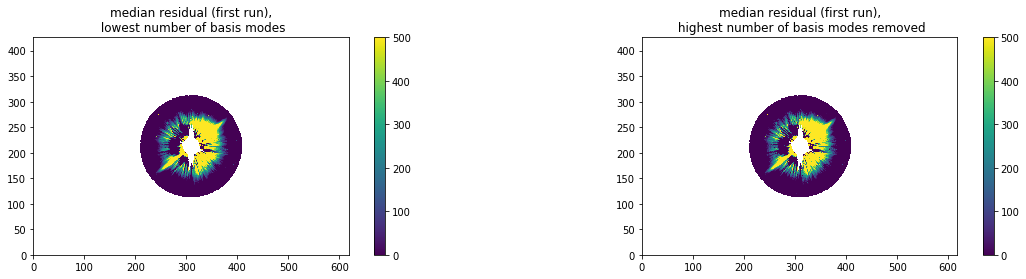

In [20]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=[20,4])

plt.subplot(121)
plt.title("median residual (first run),\n lowest number of basis modes")
plt.imshow ( medianResidualPlot_yesRC1 [0,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[0] ] )
plt.colorbar()

plt.subplot(122)
plt.title("median residual (first run),\n highest number of basis modes removed")
plt.imshow ( medianResidualPlot_yesRC1 [-1,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[0] ] )
plt.colorbar()
plotName = runNumberString + "medres.png"

plt.savefig ( outputFolder + plotName , dpi = 150 )

In [21]:
outputFolderSplit       = outputFolder.split('/')
logFilePrefix           = outputFolderSplit[1]
logFilesFromPrnft       = glob.glob ( "logsFolder/*" )

for eachLogFile in logFilesFromPrnft : 
    eachLogFileBasename = os.path.basename ( eachLogFile )
    os.rename ("logsFolder/" + eachLogFileBasename, outputFolder + "/" + logFilePrefix + "_" + eachLogFileBasename) 